In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip -q install soundfile


Mixed: /content/drive/MyDrive/asr_outputs/mixed.wav
Speakers: [1, 2, 3, 4]
  spk1: GT=/content/drive/MyDrive/asr_outputs/s1o.wav | Pred=/content/drive/MyDrive/asr_outputs/s1p.wav
  spk2: GT=/content/drive/MyDrive/asr_outputs/s2o.wav | Pred=/content/drive/MyDrive/asr_outputs/s2p.wav
  spk3: GT=/content/drive/MyDrive/asr_outputs/s3o.wav | Pred=/content/drive/MyDrive/asr_outputs/s3p.wav
  spk4: GT=/content/drive/MyDrive/asr_outputs/s4o.wav | Pred=/content/drive/MyDrive/asr_outputs/s4p.wav
Best avg SI-SDR: 4.012263119220734
Best perm (pred index for each GT speaker): [0, 1, 2, 3]
Per-speaker SI-SDR: [4.065093994140625, 3.0880868434906006, 3.5410046577453613, 5.354866981506348]
Saved: report_figs/fig_sisdr_bar.png


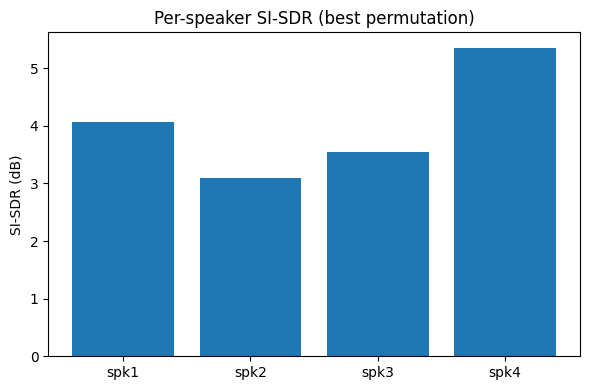

Saved: report_figs/fig_mixture_wave.png


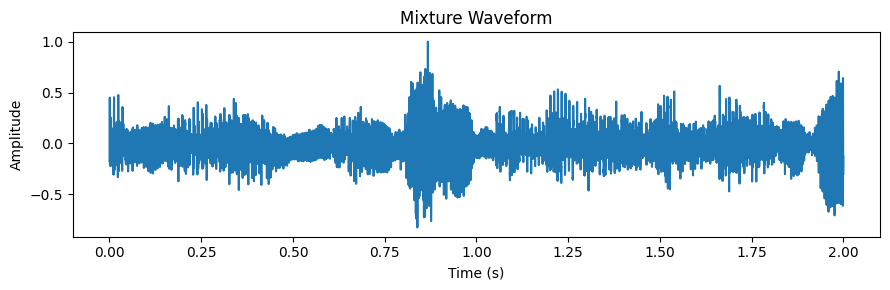

Saved: report_figs/fig_mixture_spec.png


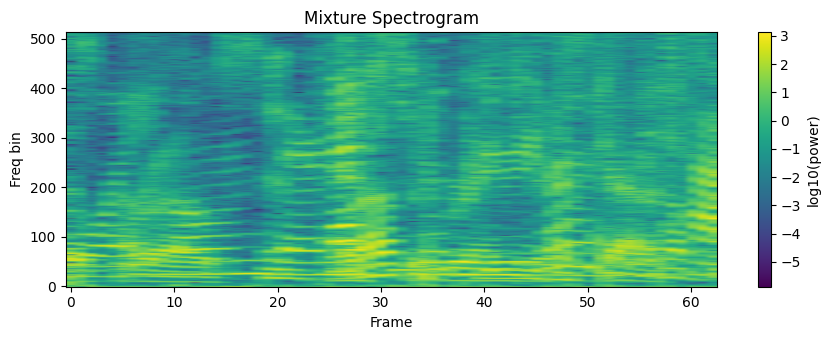

Saved: report_figs/fig_spk1_wave_compare.png


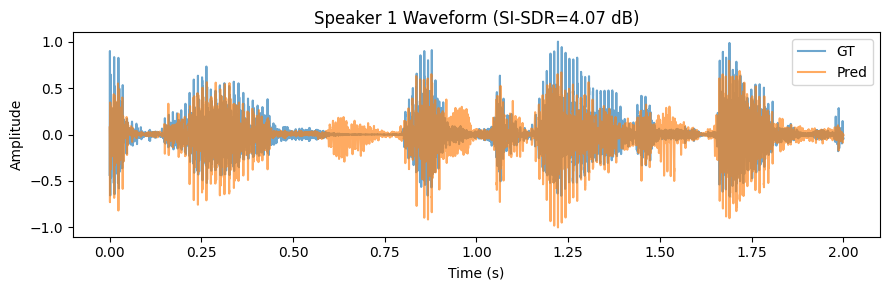

Saved: report_figs/fig_spk1_spec_compare.png


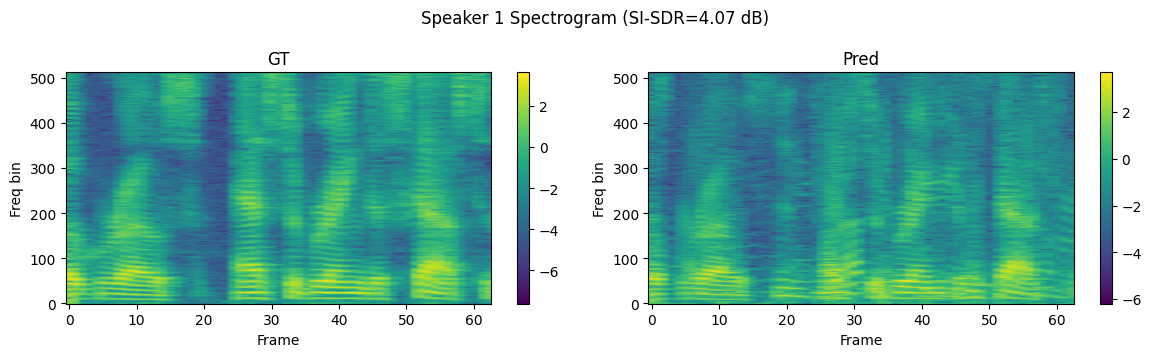

Saved: report_figs/fig_spk2_wave_compare.png


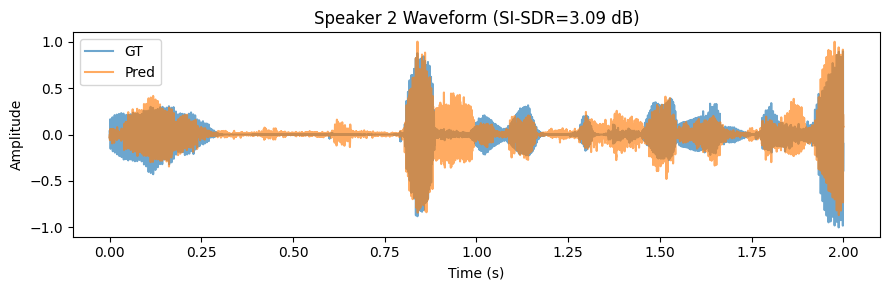

Saved: report_figs/fig_spk2_spec_compare.png


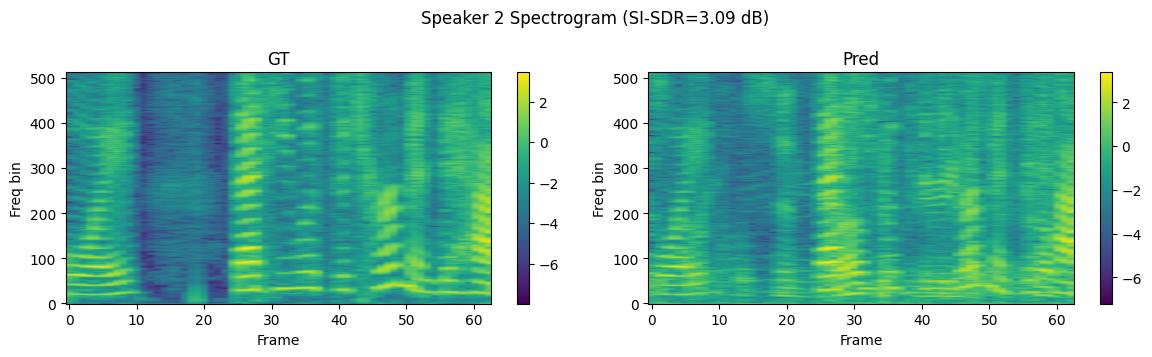

Saved: report_figs/fig_spk3_wave_compare.png


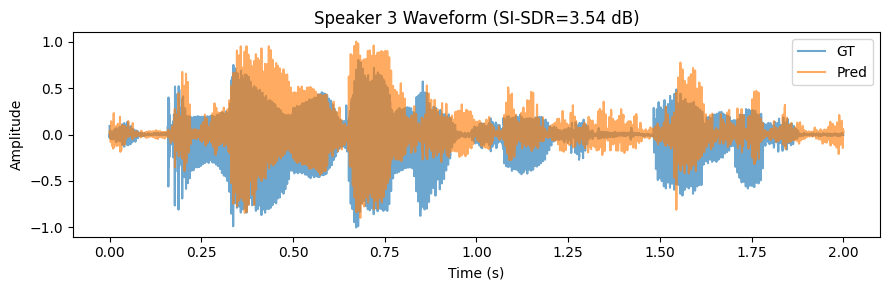

Saved: report_figs/fig_spk3_spec_compare.png


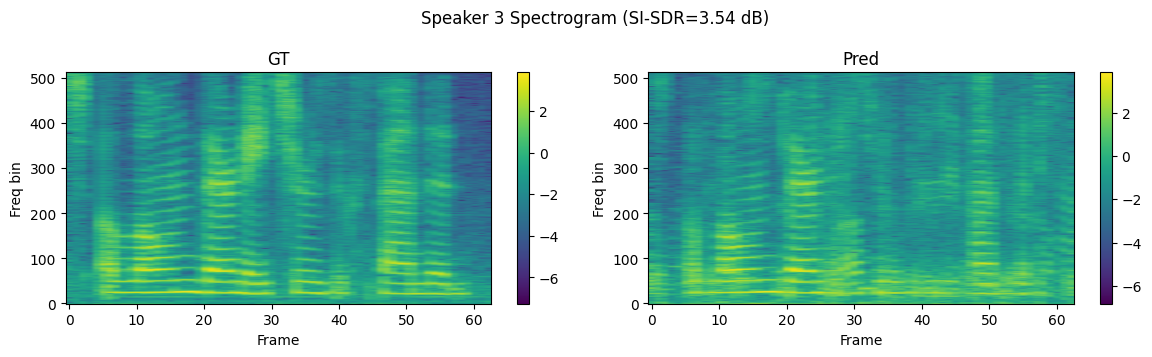

Saved: report_figs/fig_spk4_wave_compare.png


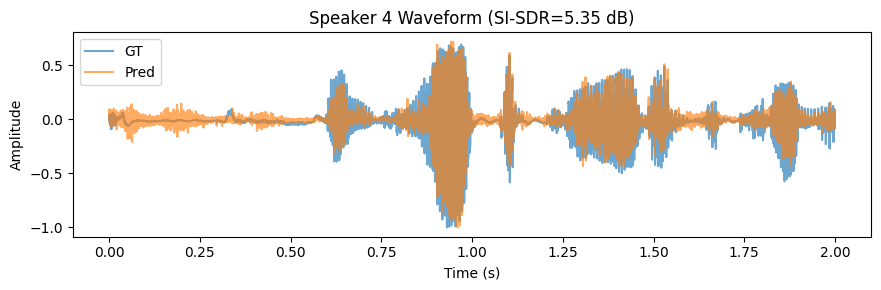

Saved: report_figs/fig_spk4_spec_compare.png


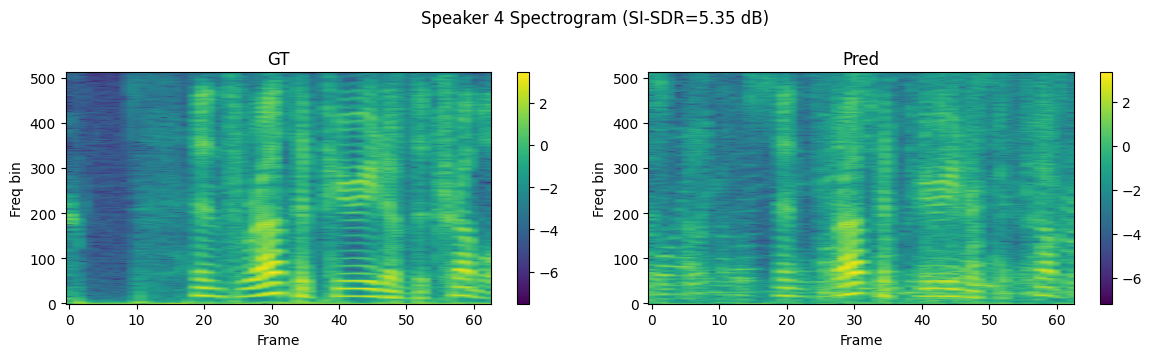

Saved: report_figs/fig_residual_wave.png


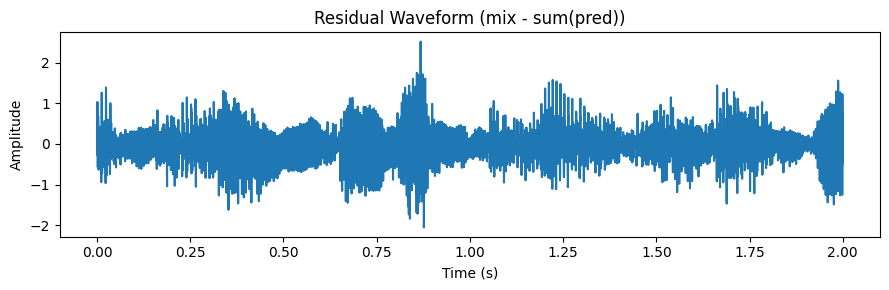

Saved: report_figs/fig_residual_spec.png


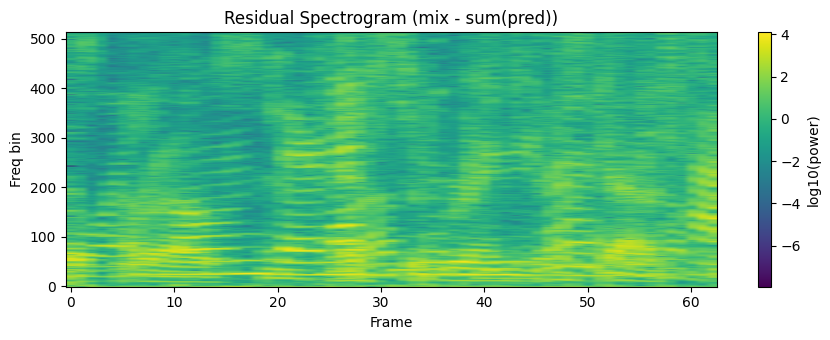

Zipped: report_figs.zip


In [ ]:
import os, re, math, glob
import numpy as np
import torch
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import soundfile as sf


DATA_DIR = "/content/drive/MyDrive/asr_outputs"
OUT_DIR  = "report_figs"
os.makedirs(OUT_DIR, exist_ok=True)

TARGET_SR = None 

def savefig(name):
    path = os.path.join(OUT_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)

def load_wav_mono(path, target_sr=None):
    x, sr = sf.read(path, always_2d=True)   # (T, C)
    x = x.mean(axis=1)                      # -> mono (T,)

    if target_sr is not None and sr != target_sr:
        import librosa
        x = librosa.resample(x, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    return torch.tensor(x, dtype=torch.float32), sr

def align_length(*waves):
    L = min([w.numel() for w in waves])
    return [w[:L] for w in waves]

def si_sdr(est, ref, eps=1e-8):
    # est/ref: (T,)
    ref_energy = torch.sum(ref**2) + eps
    alpha = torch.sum(est * ref) / ref_energy
    s_target = alpha * ref
    e_noise = est - s_target
    return 10.0 * torch.log10((torch.sum(s_target**2) + eps) / (torch.sum(e_noise**2) + eps))

def best_perm_sisdr(ests, refs):
    """
    ests/refs: (S,T)
    return: best_avg_sisdr(float), best_perm(list), per_spk_sisdr(list)
    """
    S = refs.shape[0]
    perms = list(__import__("itertools").permutations(range(S)))
    best_avg = -1e9
    best_perm = None
    best_per_spk = None
    for p in perms:
        per = []
        for i in range(S):
            per.append(si_sdr(ests[p[i]], refs[i]).item())
        avg = sum(per) / S
        if avg > best_avg:
            best_avg = avg
            best_perm = list(p)
            best_per_spk = per
    return best_avg, best_perm, best_per_spk

def plot_wave(x, sr, title, fname):
    x = x.detach().cpu().numpy()
    t = np.arange(len(x)) / sr
    plt.figure(figsize=(9,3))
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    savefig(fname)
    plt.show()

def plot_spec(x, sr, title, fname, n_fft=1024, hop=256):
    # log-power spectrogram
    x = x.detach().cpu()
    spec = T.Spectrogram(n_fft=n_fft, hop_length=hop, power=2.0)(x.unsqueeze(0))  # (1,F,T)
    spec_db = torch.log10(spec + 1e-8).squeeze(0).numpy()

    plt.figure(figsize=(9,3.5))
    plt.imshow(spec_db, aspect="auto", origin="lower")
    plt.colorbar(label="log10(power)")
    plt.xlabel("Frame")
    plt.ylabel("Freq bin")
    plt.title(title)
    savefig(fname)
    plt.show()

def plot_compare_wave(gt, pred, sr, title, fname, label_gt="GT", label_pred="Pred"):
    gt = gt.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()
    L = min(len(gt), len(pred))
    t = np.arange(L) / sr

    plt.figure(figsize=(9,3))
    plt.plot(t, gt[:L], label=label_gt, alpha=0.65)
    plt.plot(t, pred[:L], label=label_pred, alpha=0.65)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    savefig(fname)
    plt.show()

def plot_compare_spec(gt, pred, sr, title, fname, n_fft=1024, hop=256):
    gt = gt.detach().cpu()
    pred = pred.detach().cpu()
    L = min(gt.numel(), pred.numel())
    gt = gt[:L]
    pred = pred[:L]

    def to_db(w):
        s = T.Spectrogram(n_fft=n_fft, hop_length=hop, power=2.0)(w.unsqueeze(0))
        return torch.log10(s + 1e-8).squeeze(0).numpy()

    gt_db = to_db(gt)
    pr_db = to_db(pred)

    plt.figure(figsize=(12,3.6))
    plt.subplot(1,2,1)
    plt.imshow(gt_db, aspect="auto", origin="lower")
    plt.title("GT")
    plt.xlabel("Frame"); plt.ylabel("Freq bin")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(pr_db, aspect="auto", origin="lower")
    plt.title("Pred")
    plt.xlabel("Frame"); plt.ylabel("Freq bin")
    plt.colorbar()

    plt.suptitle(title)
    savefig(fname)
    plt.show()

def find_files(data_dir):
    # 接受 mixed 或 mixed.wav
    mixed_candidates = [os.path.join(data_dir, "mixed.wav"), os.path.join(data_dir, "mixed")]
    mixed_path = None
    for c in mixed_candidates:
        if os.path.exists(c):
            mixed_path = c
            break
    if mixed_path is None:
        g = glob.glob(os.path.join(data_dir, "mixed*.wav"))
        if g:
            mixed_path = g[0]
    if mixed_path is None:
        raise FileNotFoundError("找不到 mixed(.wav)。請確認檔名是 mixed 或 mixed.wav")

    # 找 s#o / s#p
    wavs = glob.glob(os.path.join(data_dir, "*.wav")) + glob.glob(os.path.join(data_dir, "*"))
    pat = re.compile(r"^s(\d+)([op])(\.wav)?$")

    gt = {}
    pr = {}
    for f in wavs:
        base = os.path.basename(f)
        m = pat.match(base)
        if not m:
            continue
        idx = int(m.group(1))
        typ = m.group(2)
        if typ == "o":
            gt[idx] = f
        else:
            pr[idx] = f

    speakers = sorted(set(gt.keys()) & set(pr.keys()))
    if not speakers:
        raise FileNotFoundError("找不到成對的 s#o / s#p（例如 s1o.wav + s1p.wav）。")

    return mixed_path, speakers, gt, pr

mixed_path, speakers, gt_files, pr_files = find_files(DATA_DIR)
print("Mixed:", mixed_path)
print("Speakers:", speakers)
for k in speakers:
    print(f"  spk{k}: GT={gt_files[k]} | Pred={pr_files[k]}")

mix_wav, sr_mix = load_wav_mono(mixed_path, TARGET_SR)

refs = []
ests = []
for k in speakers:
    r, sr_r = load_wav_mono(gt_files[k], TARGET_SR)
    e, sr_e = load_wav_mono(pr_files[k], TARGET_SR)
    if sr_r != sr_mix or sr_e != sr_mix:
        raise ValueError(f"sample rate 不一致：mix={sr_mix}, gt={sr_r}, pred={sr_e}。請設 TARGET_SR 讓它們統一。")
    r, e, mix_wav = align_length(r, e, mix_wav)  # 對齊長度（也順便裁 mix）
    refs.append(r)
    ests.append(e)

refs = torch.stack(refs, dim=0)  # (S,T)
ests = torch.stack(ests, dim=0)  # (S,T)

best_avg, perm, per_spk = best_perm_sisdr(ests, refs)
print("Best avg SI-SDR:", best_avg)
print("Best perm (pred index for each GT speaker):", perm)
print("Per-speaker SI-SDR:", per_spk)

ests_aligned = ests[torch.tensor(perm)]


plt.figure(figsize=(6,4))
plt.bar([f"spk{i+1}" for i in range(len(speakers))], per_spk)
plt.ylabel("SI-SDR (dB)")
plt.title("Per-speaker SI-SDR (best permutation)")
savefig("fig_sisdr_bar.png")
plt.show()

plot_wave(mix_wav, sr_mix, "Mixture Waveform", "fig_mixture_wave.png")
plot_spec(mix_wav, sr_mix, "Mixture Spectrogram", "fig_mixture_spec.png")

# (C) 每個 speaker：GT vs Pred waveform + spectrogram
S = len(speakers)
for i in range(S):
    gt_i = refs[i]
    pr_i = ests_aligned[i]
    plot_compare_wave(gt_i, pr_i, sr_mix,
                      f"Speaker {i+1} Waveform (SI-SDR={per_spk[i]:.2f} dB)",
                      f"fig_spk{i+1}_wave_compare.png")
    plot_compare_spec(gt_i, pr_i, sr_mix,
                      f"Speaker {i+1} Spectrogram (SI-SDR={per_spk[i]:.2f} dB)",
                      f"fig_spk{i+1}_spec_compare.png")

recon = ests.sum(dim=0)
residual = mix_wav - recon
plot_wave(residual, sr_mix, "Residual Waveform (mix - sum(pred))", "fig_residual_wave.png")
plot_spec(residual, sr_mix, "Residual Spectrogram (mix - sum(pred))", "fig_residual_spec.png")

# (E) 打包
import zipfile
zip_path = "report_figs.zip"
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for fn in os.listdir(OUT_DIR):
        z.write(os.path.join(OUT_DIR, fn), arcname=os.path.join(OUT_DIR, fn))
print("Zipped:", zip_path)


Best speaker index: 3 SI-SDR: 5.354866981506348
Worst speaker index: 1 SI-SDR: 3.0880868434906006
Global spectrogram color scale: -3.792067 1.1355728
Saved: report_figs/fig_mixture_wave.png


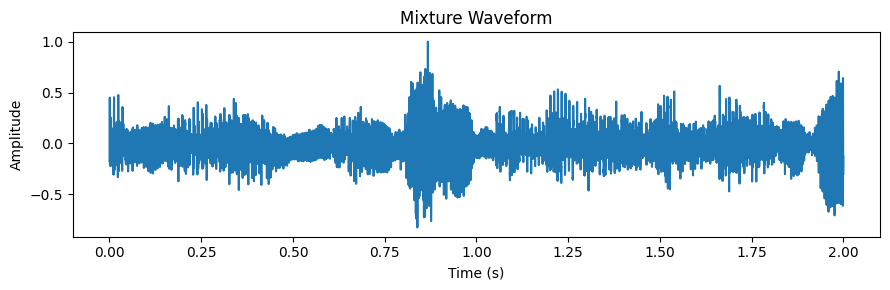

Saved: report_figs/fig_mixture_spec.png


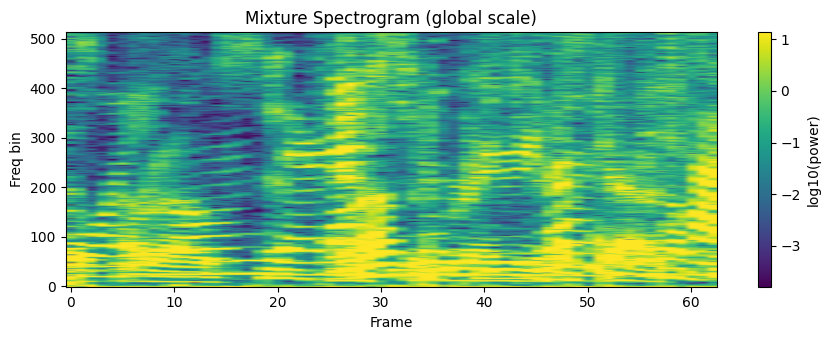

Saved: report_figs/fig_best_spk4_wave.png


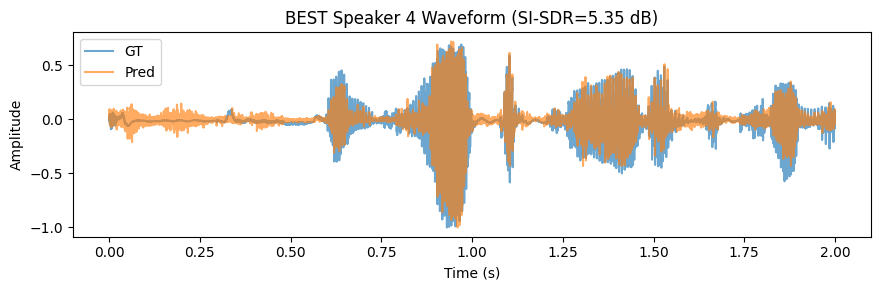

Saved: report_figs/fig_best_spk4_spec.png


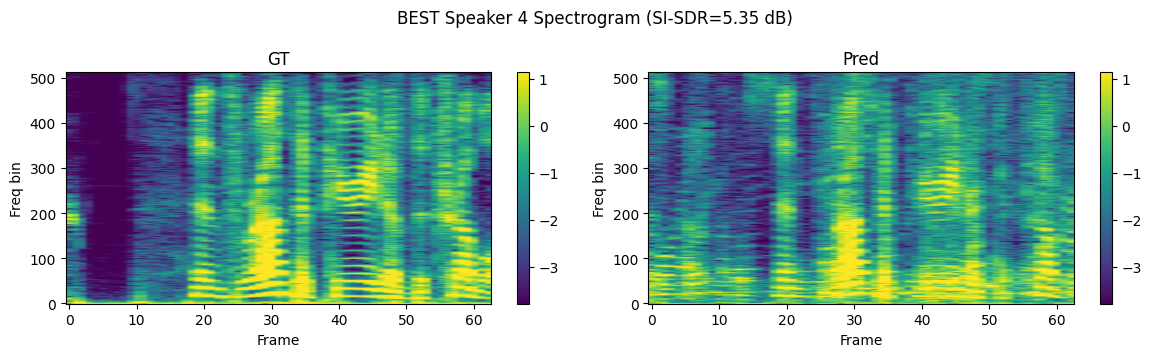

Saved: report_figs/fig_worst_spk2_wave.png


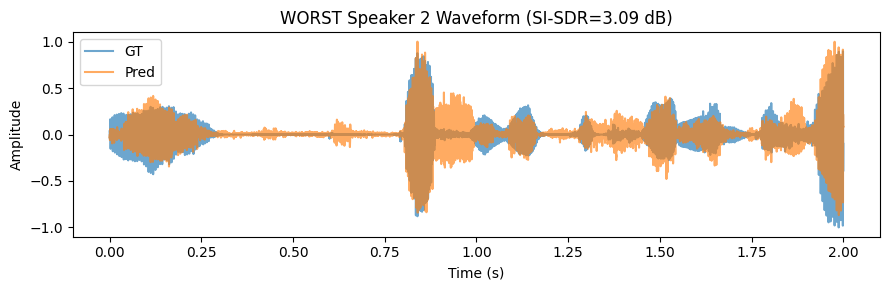

Saved: report_figs/fig_worst_spk2_spec.png


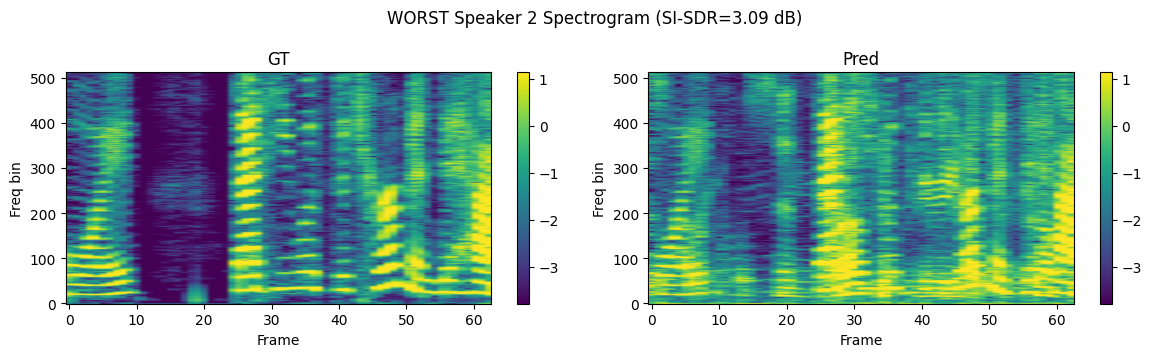

Saved: report_figs/fig_residual_wave.png


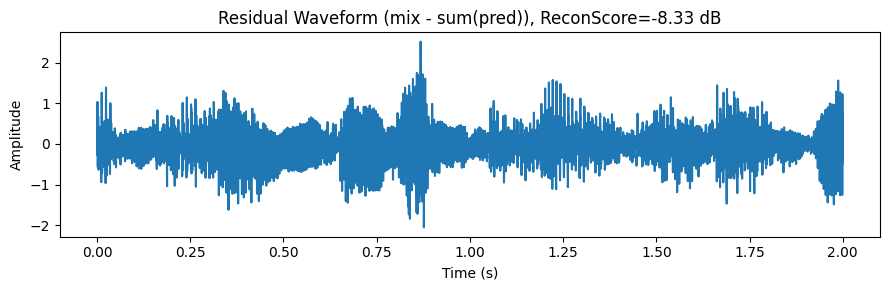

Saved: report_figs/fig_residual_spec.png


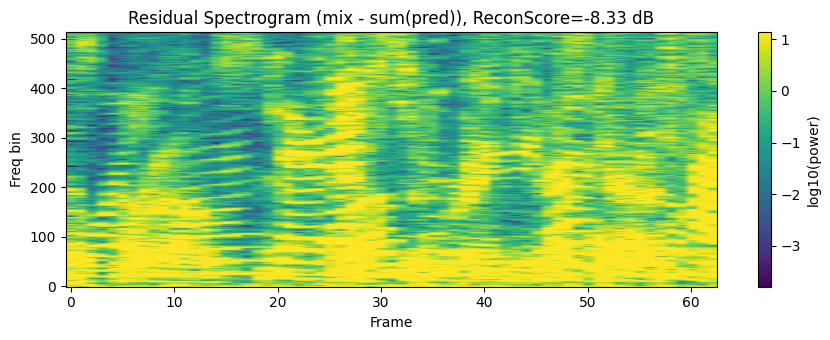

ReconScore (dB) = -8.330276489257812
All figures saved to: report_figs


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchaudio.transforms as T

OUT_DIR = "report_figs"
os.makedirs(OUT_DIR, exist_ok=True)

def savefig(name):
    path = os.path.join(OUT_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print("Saved:", path)

# ---------- plots ----------
def plot_wave(x, sr, title, fname, ylim=None):
    x = x.detach().cpu().numpy()
    t = np.arange(len(x)) / sr
    plt.figure(figsize=(9,3))
    plt.plot(t, x)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    if ylim is not None:
        plt.ylim(ylim)
    savefig(fname)
    plt.show()

def plot_compare_wave(gt, pred, sr, title, fname, ylim=None):
    gt = gt.detach().cpu().numpy()
    pred = pred.detach().cpu().numpy()
    L = min(len(gt), len(pred))
    t = np.arange(L) / sr
    plt.figure(figsize=(9,3))
    plt.plot(t, gt[:L], label="GT", alpha=0.65)
    plt.plot(t, pred[:L], label="Pred", alpha=0.65)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    if ylim is not None:
        plt.ylim(ylim)
    savefig(fname)
    plt.show()

def spec_db(x, n_fft=1024, hop=256):
    x = x.detach().cpu()
    S = T.Spectrogram(n_fft=n_fft, hop_length=hop, power=2.0)(x.unsqueeze(0))  # (1,F,T)
    return torch.log10(S + 1e-8).squeeze(0).numpy()  # (F,T)

def plot_spec_fixed(db, title, fname, vmin=None, vmax=None):
    plt.figure(figsize=(9,3.5))
    plt.imshow(db, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
    plt.colorbar(label="log10(power)")
    plt.xlabel("Frame")
    plt.ylabel("Freq bin")
    plt.title(title)
    savefig(fname)
    plt.show()

def plot_compare_spec_same_scale_from_db(gt_db, pr_db, title, fname, vmin, vmax):
    plt.figure(figsize=(12,3.6))
    plt.subplot(1,2,1)
    plt.imshow(gt_db, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
    plt.title("GT")
    plt.xlabel("Frame"); plt.ylabel("Freq bin")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.imshow(pr_db, aspect="auto", origin="lower", vmin=vmin, vmax=vmax)
    plt.title("Pred")
    plt.xlabel("Frame"); plt.ylabel("Freq bin")
    plt.colorbar()

    plt.suptitle(title)
    savefig(fname)
    plt.show()

# =========================
# 0) choose best/worst
# =========================
per_spk_np = np.array(per_spk, dtype=float)
best_i = int(np.argmax(per_spk_np))
worst_i = int(np.argmin(per_spk_np))

print("Best speaker index:", best_i, "SI-SDR:", per_spk_np[best_i])
print("Worst speaker index:", worst_i, "SI-SDR:", per_spk_np[worst_i])

# =========================
# 1) GLOBAL vmin/vmax for ALL spectrograms
#    (mixture + all GT/Pred) -> fair color scale
# =========================
db_list = []
mix_db = spec_db(mix_wav)
db_list.append(mix_db)

for i in range(len(refs)):
    gt_i = refs[i]
    pr_i = ests_aligned[i]
    L = min(gt_i.numel(), pr_i.numel())
    gt_i = gt_i[:L]
    pr_i = pr_i[:L]
    db_list.append(spec_db(gt_i))
    db_list.append(spec_db(pr_i))

allv = np.concatenate([d.flatten() for d in db_list])
GLOBAL_VMIN = np.percentile(allv, 5)
GLOBAL_VMAX = np.percentile(allv, 95)
print("Global spectrogram color scale:", GLOBAL_VMIN, GLOBAL_VMAX)

plot_wave(mix_wav, sr_mix, "Mixture Waveform", "fig_mixture_wave.png")
plot_spec_fixed(mix_db, "Mixture Spectrogram (global scale)", "fig_mixture_spec.png",
                vmin=GLOBAL_VMIN, vmax=GLOBAL_VMAX)

for tag, i in [("best", best_i), ("worst", worst_i)]:
    gt_i = refs[i]
    pr_i = ests_aligned[i]
    L = min(gt_i.numel(), pr_i.numel())
    gt_i = gt_i[:L]
    pr_i = pr_i[:L]

    sisdr_i = per_spk_np[i]

    plot_compare_wave(
        gt_i, pr_i, sr_mix,
        f"{tag.upper()} Speaker {i+1} Waveform (SI-SDR={sisdr_i:.2f} dB)",
        f"fig_{tag}_spk{i+1}_wave.png"
    )

    # spectrogram GT vs Pred with SAME global scale
    gt_db = spec_db(gt_i)
    pr_db = spec_db(pr_i)
    plot_compare_spec_same_scale_from_db(
        gt_db, pr_db,
        f"{tag.upper()} Speaker {i+1} Spectrogram (SI-SDR={sisdr_i:.2f} dB)",
        f"fig_{tag}_spk{i+1}_spec.png",
        vmin=GLOBAL_VMIN, vmax=GLOBAL_VMAX
    )

eps = 1e-8
recon = ests.sum(dim=0)
residual = mix_wav - recon

recon_score = 10 * torch.log10((mix_wav.pow(2).mean() + eps) / (residual.pow(2).mean() + eps))
recon_score = float(recon_score.item())

plot_wave(residual, sr_mix,
          f"Residual Waveform (mix - sum(pred)), ReconScore={recon_score:.2f} dB",
          "fig_residual_wave.png")

res_db = spec_db(residual)
plot_spec_fixed(res_db,
                f"Residual Spectrogram (mix - sum(pred)), ReconScore={recon_score:.2f} dB",
                "fig_residual_spec.png",
                vmin=GLOBAL_VMIN, vmax=GLOBAL_VMAX)

print("ReconScore (dB) =", recon_score)
print("All figures saved to:", OUT_DIR)


# Wiener 後處理


In [ ]:
!pip -q install soundfile librosa

import os, glob
import numpy as np
import soundfile as sf
import librosa

DATA_DIR = "/content/drive/MyDrive/asr_outputs"
OUT_DIR  = "/content/drive/MyDrive/asr_outputs_wiener"
os.makedirs(OUT_DIR, exist_ok=True)

gamma = 1.45 

def load_mono(path):
    x, sr = sf.read(path, always_2d=True)
    x = x.mean(axis=1).astype(np.float32)
    return x, sr

def save(path, x, sr):
    sf.write(path, x, sr)

def align_len(*xs):
    L = min(len(x) for x in xs)
    return [x[:L] for x in xs]

def peak_norm(x, target=0.8912509):  # -1 dBFS
    p = np.max(np.abs(x)) + 1e-12
    return x * (target/p)

mix_path = os.path.join(DATA_DIR, "mixed.wav")
pred_files = sorted(glob.glob(os.path.join(DATA_DIR, "s*p.wav")))
assert os.path.exists(mix_path), "找不到 mixed.wav"
assert len(pred_files) > 0, "找不到 s*p.wav"

mix, sr = load_mono(mix_path)

preds = []
for p in pred_files:
    y, sr2 = load_mono(p)
    if sr2 != sr:
        raise ValueError(f"SR不一致：mix={sr}, {p}={sr2}")
    preds.append(y)

mix, *preds = align_len(mix, *preds)
preds = np.stack(preds, axis=0)  # (S,T)
S, T = preds.shape

# ---- STFT ----
n_fft = 1024
hop   = 256
win   = "hann"

X = librosa.stft(mix, n_fft=n_fft, hop_length=hop, window=win)  # (F,TT)

# 每路預測的功率譜 P_i
P = []
for i in range(S):
    Si = librosa.stft(preds[i], n_fft=n_fft, hop_length=hop, window=win)
    P.append(np.abs(Si)**2)
P = np.stack(P, axis=0)

eps = 1e-10
P_gamma = P ** gamma
Psum = np.sum(P_gamma, axis=0) + eps
masks = P_gamma / Psum[None, :, :]

outs = []
for i in range(S):
    Yi = masks[i] * X
    yi = librosa.istft(Yi, hop_length=hop, window=win, length=T)
    outs.append(peak_norm(yi.astype(np.float32)))
outs = np.stack(outs, axis=0)

# ---- save ----
for i, p in enumerate(pred_files):
    base = os.path.basename(p).replace(".wav", "")
    out_path = os.path.join(OUT_DIR, f"{base}_wf.wav")
    save(out_path, outs[i], sr)
    print("Saved:", out_path)

print("Done. gamma =", gamma, "Output:", OUT_DIR)


Saved: /content/drive/MyDrive/asr_outputs_wiener/s1p_wf.wav
Saved: /content/drive/MyDrive/asr_outputs_wiener/s2p_wf.wav
Saved: /content/drive/MyDrive/asr_outputs_wiener/s3p_wf.wav
Saved: /content/drive/MyDrive/asr_outputs_wiener/s4p_wf.wav
Done. gamma = 1.45 Output: /content/drive/MyDrive/asr_outputs_wiener


Speaker 1


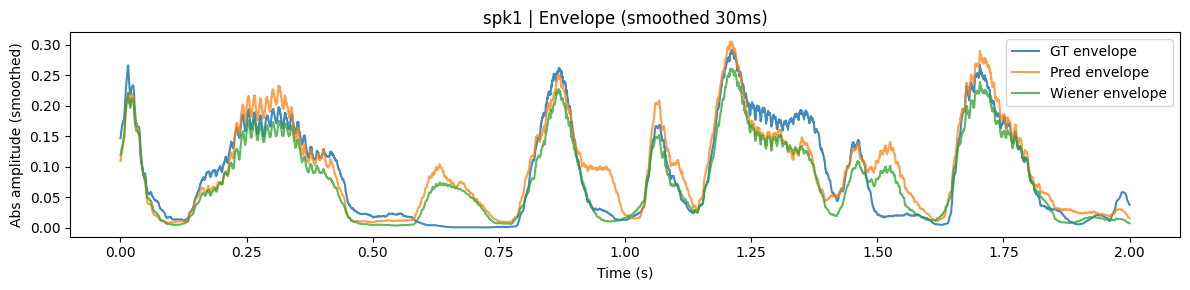

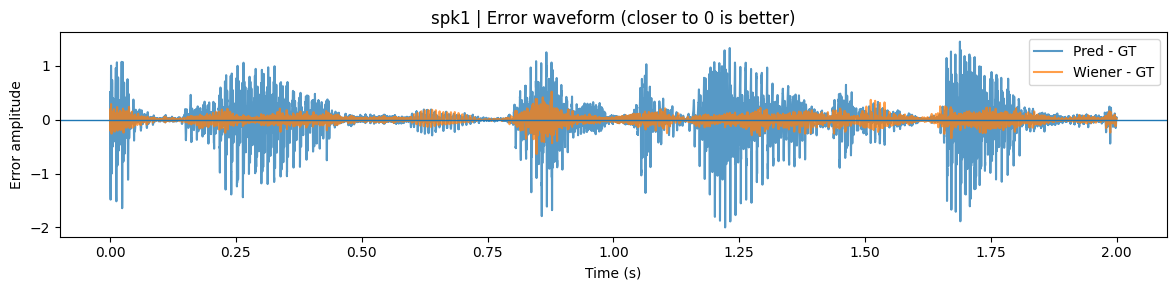

Speaker 2


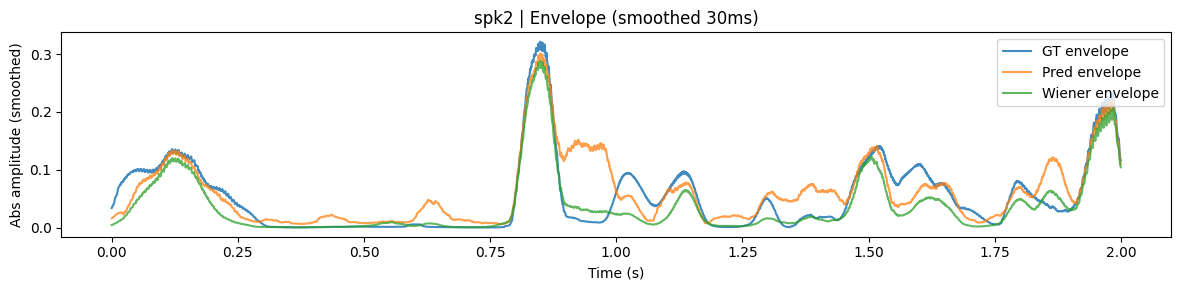

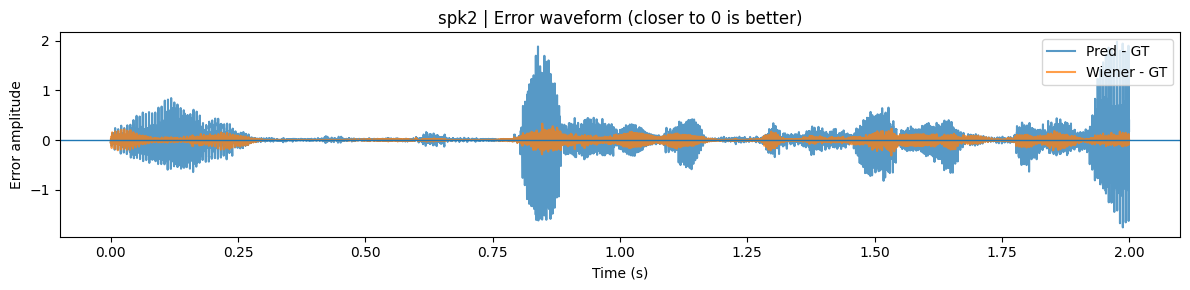

Speaker 3


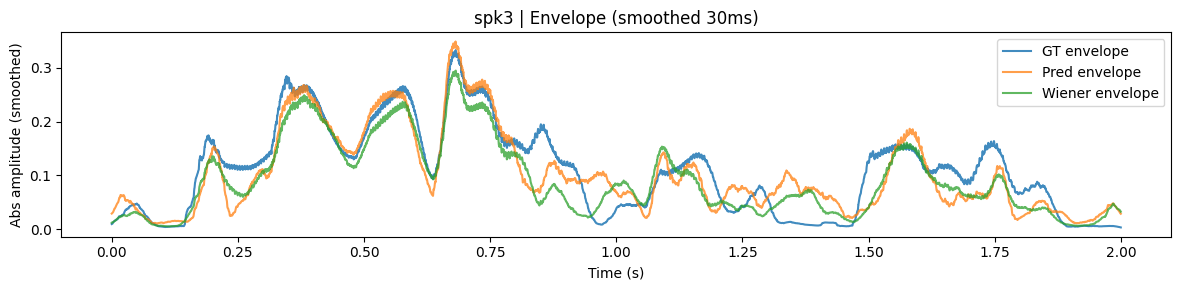

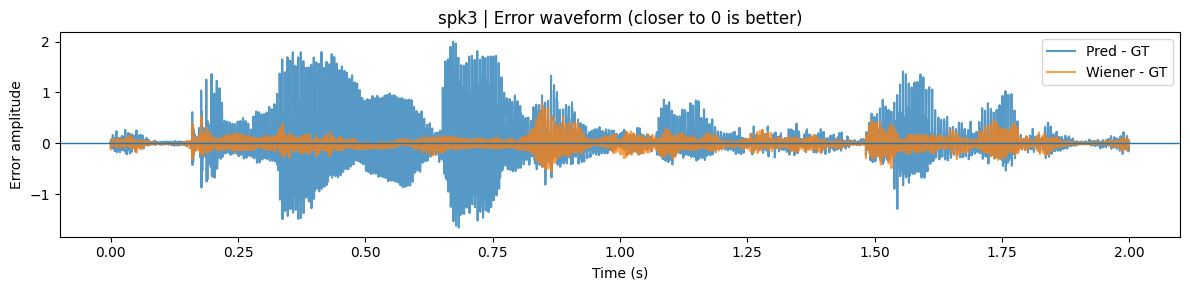

Speaker 4


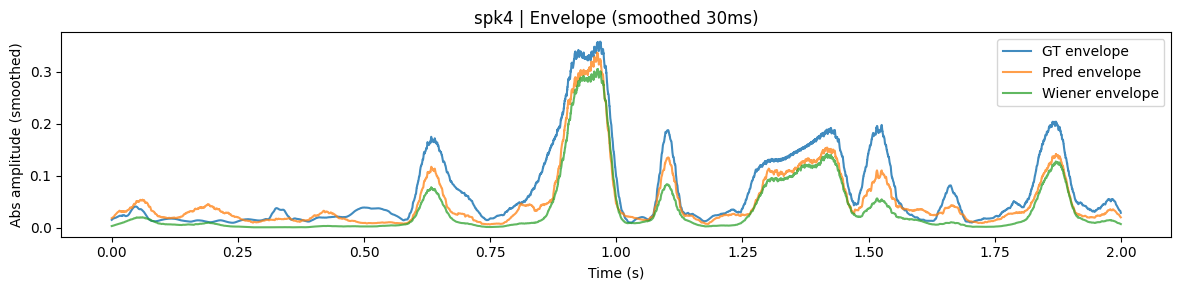

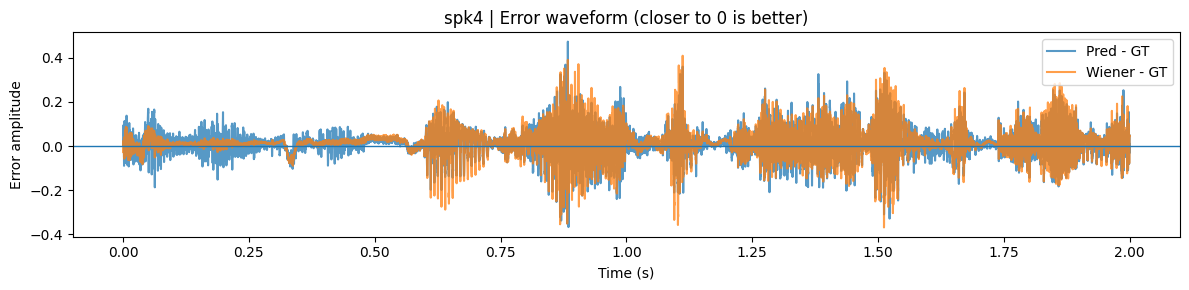

Done.


In [ ]:
!pip -q install soundfile librosa

import os, glob, re
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio, display

DATA_DIR = "/content/drive/MyDrive/asr_outputs"
WF_DIR   = "/content/drive/MyDrive/asr_outputs_wiener"

PLOT_SECONDS = 8          # None = full length (usually too long)
ENVELOPE_MS  = 30         # smoothing window for envelope (ms)
PLAY_AUDIO   = False      # True to play GT/Pred/Wiener for each speaker

def load_mono(path):
    x, sr = sf.read(path, always_2d=True)
    x = x.mean(axis=1).astype(np.float32)
    return x, sr

def align3(a, b, c):
    L = min(len(a), len(b), len(c))
    return a[:L], b[:L], c[:L], L

def crop_seconds(x, sr, seconds):
    if seconds is None:
        return x
    L = min(len(x), int(seconds * sr))
    return x[:L]

def moving_avg(x, win):
    win = max(1, int(win))
    k = np.ones(win, dtype=np.float32) / win
    return np.convolve(x, k, mode="same")

def plot_envelope_overlay(gt, pred, wf, sr, title, max_seconds=8, smooth_ms=30):
    gt = crop_seconds(gt, sr, max_seconds)
    pred = crop_seconds(pred, sr, max_seconds)
    wf = crop_seconds(wf, sr, max_seconds)

    gt, pred, wf, L = align3(gt, pred, wf)
    t = np.arange(L) / sr

    win = int(sr * smooth_ms / 1000)
    e_gt   = moving_avg(np.abs(gt), win)
    e_pred = moving_avg(np.abs(pred), win)
    e_wf   = moving_avg(np.abs(wf), win)

    plt.figure(figsize=(12,3))
    plt.plot(t, e_gt,   label="GT envelope", alpha=0.85)
    plt.plot(t, e_pred, label="Pred envelope", alpha=0.75)
    plt.plot(t, e_wf,   label="Wiener envelope", alpha=0.75)
    plt.title(f"{title} | Envelope (smoothed {smooth_ms}ms)")
    plt.xlabel("Time (s)")
    plt.ylabel("Abs amplitude (smoothed)")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

def plot_error_overlay(gt, pred, wf, sr, title, max_seconds=8):
    gt = crop_seconds(gt, sr, max_seconds)
    pred = crop_seconds(pred, sr, max_seconds)
    wf = crop_seconds(wf, sr, max_seconds)

    gt, pred, wf, L = align3(gt, pred, wf)
    t = np.arange(L) / sr

    err_pred = pred - gt
    err_wf   = wf - gt

    plt.figure(figsize=(12,3))
    plt.plot(t, err_pred, label="Pred - GT", alpha=0.75)
    plt.plot(t, err_wf,   label="Wiener - GT", alpha=0.75)
    plt.axhline(0, linewidth=1)
    plt.title(f"{title} | Error waveform (closer to 0 is better)")
    plt.xlabel("Time (s)")
    plt.ylabel("Error amplitude")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

#auto find speakers
gt_files = glob.glob(os.path.join(DATA_DIR, "s*o.wav"))
pat = re.compile(r"^s(\d+)o\.wav$")
spks = sorted([int(pat.match(os.path.basename(f)).group(1)) for f in gt_files if pat.match(os.path.basename(f))])

if not spks:
    raise FileNotFoundError("在 DATA_DIR 找不到 s#o.wav（例如 s1o.wav）")

for spk in spks:
    gt_path   = os.path.join(DATA_DIR, f"s{spk}o.wav")
    pred_path = os.path.join(DATA_DIR, f"s{spk}p.wav")
    wf_path   = os.path.join(WF_DIR,  f"s{spk}p_wf.wav")

    if not (os.path.exists(gt_path) and os.path.exists(pred_path) and os.path.exists(wf_path)):
        print(f"[Skip] spk{spk}: missing file(s)")
        continue

    gt, sr1   = load_mono(gt_path)
    pred, sr2 = load_mono(pred_path)
    wf, sr3   = load_mono(wf_path)

    if not (sr1 == sr2 == sr3):
        raise ValueError(f"SR 不一致：spk{spk} gt={sr1}, pred={sr2}, wf={sr3}")

    print("="*70)
    print(f"Speaker {spk}")

    if PLAY_AUDIO:
        print("GT"); display(Audio(gt, rate=sr1))
        print("Pred"); display(Audio(pred, rate=sr1))
        print("Wiener"); display(Audio(wf, rate=sr1))

    # (1) Envelope overlay: easiest to see leakage / over-energy
    plot_envelope_overlay(gt, pred, wf, sr1,
                          title=f"spk{spk}",
                          max_seconds=PLOT_SECONDS,
                          smooth_ms=ENVELOPE_MS)

    # (2) Error overlay: easiest to see how much mismatch remains
    plot_error_overlay(gt, pred, wf, sr1,
                       title=f"spk{spk}",
                       max_seconds=PLOT_SECONDS)

print("Done.")


Mean SI-SDR original : 4.012263774871826
Mean SI-SDR wiener   : 5.85333776473999
Mean improvement Δ   : 1.841073989868164
Median improvement Δ : 1.644171953201294
Relative improvement : 0.45886165346308

Per-speaker improvement:
  Speaker 1: Δ +1.92 dB
  Speaker 2: Δ +3.59 dB
  Speaker 3: Δ +1.36 dB
  Speaker 4: Δ +0.49 dB


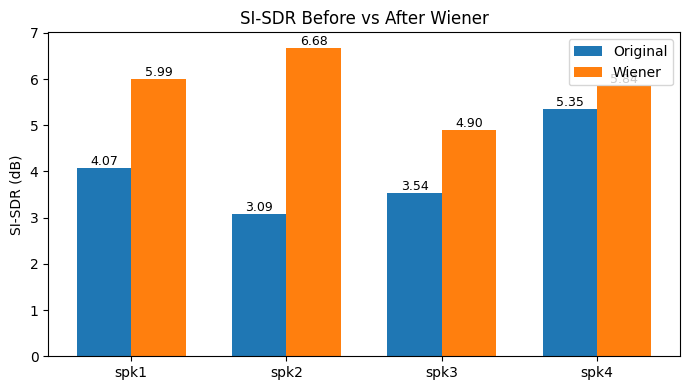

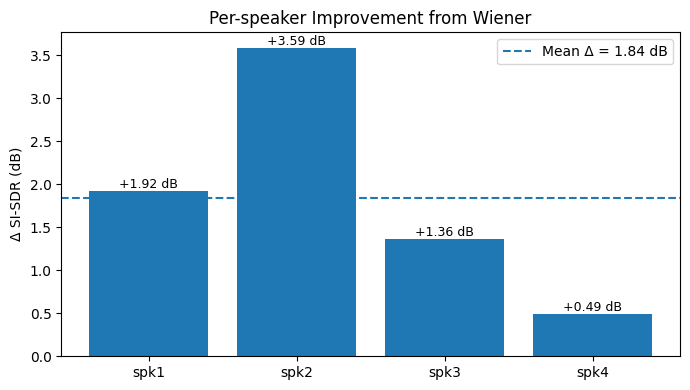

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# results: [(spk, s0, s1, ds), ...]
spk = [r[0] for r in results]
s0  = np.array([r[1] for r in results], dtype=float)
s1  = np.array([r[2] for r in results], dtype=float)
ds  = np.array([r[3] for r in results], dtype=float)


print("Mean SI-SDR original :", s0.mean())
print("Mean SI-SDR wiener   :", s1.mean())
print("Mean improvement Δ   :", ds.mean())
print("Median improvement Δ :", np.median(ds))
print("Relative improvement :", ds.mean() / (s0.mean() + 1e-12))
print("\nPer-speaker improvement:")
for i, d in zip(spk, ds):
    print(f"  Speaker {i}: Δ {d:+.2f} dB")

#Before vs After
plt.figure(figsize=(7,4))
x = np.arange(len(spk))
w = 0.35
plt.bar(x - w/2, s0, width=w, label="Original")
plt.bar(x + w/2, s1, width=w, label="Wiener")
plt.xticks(x, [f"spk{i}" for i in spk])
plt.ylabel("SI-SDR (dB)")
plt.title("SI-SDR Before vs After Wiener")
plt.legend()

# 在柱子上標數字
for i in range(len(spk)):
    plt.text(x[i]-w/2, s0[i], f"{s0[i]:.2f}", ha="center", va="bottom", fontsize=9)
    plt.text(x[i]+w/2, s1[i], f"{s1[i]:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Improvement Δ
plt.figure(figsize=(7,4))
bars = plt.bar([f"spk{i}" for i in spk], ds)
mean_d = ds.mean()
plt.axhline(mean_d, linestyle="--", label=f"Mean Δ = {mean_d:.2f} dB")
plt.ylabel("Δ SI-SDR (dB)")
plt.title("Per-speaker Improvement from Wiener")
plt.legend()

# 在每個 bar 上標 Δ
for bar, d in zip(bars, ds):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f"{d:+.2f} dB",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()
